# Regional category population prevalence for spectral results

In [1]:
import re
import bayesprev
import numpy as np
import pandas as pd
from scipy import stats
from mne.stats import fdr_correction
from itertools import product
from os.path import join as pjoin

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

# get subject list
print(sujs)

['sub-9d783b836f5e', 'sub-14c725b6b803', 'sub-28e70e7c7fbb', 'sub-83ebd5328120', 'sub-cacae171ee15', 'sub-95a634be7e05', 'sub-26176ef8a8d0', 'sub-44375d501493', 'sub-a4e7fc9daa96', 'sub-c1b7ce54ce05', 'sub-3ef8645f99c5', 'sub-fccb4adbfadc', 'sub-ebf231d97f73', 'sub-e0bb6ccef2a5', 'sub-4247d6d6cdbf', 'sub-45a6830d263e', 'sub-82e330f8aadd', 'sub-c2a96116ddc4']


**Small function** 

In [2]:
# shortcut to joining var strings
def jn(mlist, char=None):
    """Summary

    Parameters
    ----------
    mlist : list
       List of strings to concatenate.
    join : str, optional
       Character for concatenation.

    Returns
    -------
    Concatenated string
    """
    if char is None:
        string = '_'.join(mlist)
    else:
        string = char.join(mlist)

    return string

**Fixed variables** 

In [3]:
analysis = 'spectral'
outlier = 'noout'
alpha = .01
h5_path = pjoin('/Volumes',
                'Transcend',
                'ispeech_motorspeech_transcend',
                'projects',
                'ispeech',
                'data',
                'data_h5', )

In [4]:
cat_df = {}
b_d = {}

*Lists*

In [5]:
sounds = ['speech', 'music']
hemis = ['left', 'right']

# all bands
bands = ['delta', 'theta', 'alpha', 'beta', 'lga', 'hfa']
bands_r = ((1, 4), (5, 8), (8, 12), (18, 30), (30, 50), (80, 120))

# previous bands (delta from 1, HFa envelope correlation)
p_bands = ['delta', 'hfa']

# new custom bands
c_bands = ['theta', 'alpha', 'beta', 'lga']

*Band inidices in morlet*

In [6]:
freqs = np.logspace(np.log2(1), np.log2(150), num=100, base=2)
for b, r in zip(bands, bands_r):
    idx = [(np.abs(freqs - value)).argmin() for value in r]
    idx = (idx[0], idx[1] + 1)
    b_d[b + '_morlet_i'] = idx
    print(b, r, idx, np.round(freqs, 2)[slice(idx[0], idx[1])])

delta (1, 4) (0, 28) [1.   1.05 1.11 1.16 1.22 1.29 1.35 1.43 1.5  1.58 1.66 1.74 1.84 1.93
 2.03 2.14 2.25 2.36 2.49 2.62 2.75 2.89 3.04 3.2  3.37 3.54 3.73 3.92]
theta (5, 8) (32, 42) [5.05 5.31 5.59 5.88 6.18 6.51 6.84 7.2  7.57 7.97]
alpha (8, 12) (41, 50) [ 7.97  8.38  8.81  9.27  9.75 10.26 10.79 11.35 11.94]
beta (18, 30) (57, 68) [17.9  18.83 19.81 20.84 21.92 23.06 24.25 25.51 26.84 28.23 29.7 ]
lga (30, 50) (67, 78) [29.7  31.24 32.86 34.57 36.36 38.25 40.23 42.32 44.52 46.83 49.26]
hfa (80, 120) (87, 96) [ 81.72  85.96  90.42  95.12 100.06 105.25 110.72 116.46 122.51]


*Some little functions*

In [11]:
def get_name(data, analysis=analysis, condition=None):
    if condition:
        cname = jn([analysis, condition, data, outlier, 'sign'])
    else:
        cname = jn([analysis, 'difference', data, 'sign'])
    return cname

*Plotting colors and cmaps*

In [12]:
color = {
    'speech': [  # red
        np.array((242, 152, 154)).reshape(1, -1),
        np.array((254, 75, 73)).reshape(1, -1),
        np.array((219, 129, 130)).reshape(1, -1),
    ],
    'music': [  # blue
        np.array((148, 210, 221)).reshape(1, -1),
        np.array((43, 183, 200)).reshape(1, -1),
        np.array((114, 183, 194)).reshape(1, -1),
    ],
    'shared': [  # yellow
        np.array((243, 222, 168)).reshape(1, -1),
        np.array((255, 214, 102)).reshape(1, -1),
        np.array((220, 199, 145)).reshape(1, -1),
    ],
    'neither_grey': [  # grey
        np.array((230, 229, 234)).reshape(1, -1),
        np.array((184, 183, 187)).reshape(1, -1),
        np.array((132, 131, 134)).reshape(1, -1),
    ]}

color['shared'][1] = np.array([[255, 255, 255]])

## Prepare DataFrame

### **Collect base data** from presaved DF and add data of interest

The conditions of our ethics approval do not permit public archiving of anonymised study data. Readers seeking access to the data should contact the lead author. Access will be granted to named individuals in accordance with ethical procedures governing the reuse of clinical data, including completion of a formal data sharing agreement.

In [ ]:
# collect ispeech dataframe and add other infos
path = pjoin(h5_path, 'h5_df')
with pd.HDFStore(pjoin(path, 'ispeech_base_df.h5'), mode='r') as store:
    df = store.select('df')

### Add statistics

#### Add **difference effects** for all bands ***except HGA*** &rarr; ***morlet!***

In [10]:
columns = ['spectral_morlet_speech', 'spectral_morlet_music']

for band in bands:
    idx = b_d[band + '_morlet_i']

    data = np.array([x for x in df[columns[0]].values])
    c1 = np.nanmean(data[:, slice(idx[0], idx[1])], axis=1)
    data = np.array([x for x in df[columns[1]].values])
    c2 = np.nanmean(data[:, slice(idx[0], idx[1])], axis=1)
    tstat, pval = stats.ttest_ind(c1, c2, axis=1, nan_policy='omit')

    # correct for multiple comparison
    mask = np.isfinite(pval)
    _, pval[mask] = fdr_correction(pval[mask])

    # all sign indexes
    indexes = [x[0] for x in np.argwhere(pval < alpha)]
    sign_df = df.iloc[indexes]
    name = '%s_difference_%s' % (analysis, band)
    sign_df[jn([name, 'sign'])] = [x for x in tstat[indexes]]
    df = df.join(sign_df[jn([name, 'sign'])]).fillna(df)

#### Add **main effects** for all bands

##### Average morlet within bands

In [11]:
# reduce spectral columns
columns = ['spectral_morlet_speech', 'spectral_morlet_music']
for column, band in product(columns, bands):
    sound = 'speech' if 'speech' in column else 'music'
    idx = b_d[band + '_morlet_i']
    data = np.array([x for x in df[column].values])
    c1 = np.nanmean(data[:, slice(idx[0], idx[1])], axis=1)
    c = jn([analysis, sound, band])
    df[c] = np.nanmean(c1, 1)

##### Get rid of outliers and determine threshold

In [17]:
d = {}
l_outlier = 1
r_outlier = 2
r_sign = 1

for i, band in enumerate(bands):

    for sound in sounds:
        d_name = jn([analysis, sound, band])
        d[d_name] = df[d_name].values

    # average speech and music
    d[jn([band, 'data'])] = (d['spectral_speech_' + band] +
                             d['spectral_music_' + band]) / 2

    # determine thresholds
    for threshold, limit in zip(('loutlier', 'routlier', 'sign'), (l_outlier, r_outlier, r_sign)):
        if threshold == 'loutlier':
            d[jn([band, threshold])] = np.nanmean(d[jn([band, 'data'])]
                                                  ) - (limit * np.nanstd(d[jn([band, 'data'])]))
        else:
            d[jn([band, threshold])] = np.nanmean(d[jn([band, 'data'])]
                                                  ) + (limit * np.nanstd(d[jn([band, 'data'])]))

    # save significants without outlier removal and then remove outliers
    for sound in sounds:
        d_name = jn([analysis, sound, band])
        d[jn([d_name, 'noout'])] = [x if x < d[jn([band, 'routlier'])]
                                    and x > d[jn([band, 'loutlier'])] else np.nan for x in d[d_name]]
        df[jn([d_name, 'outlier_sign'])] = [
            x if x > d[jn([band, 'sign'])] else np.nan for x in d[d_name]]

    # average speech and music of new data
    d[jn([band, 'data_noout'])] = np.array(d['spectral_speech_' +
                                             band + '_noout'] + d['spectral_music_' + band + '_noout']) / 2

    # select significants threshold
    d[jn([band, 'sign'])] = np.nanmean(d[jn([band, 'data_noout'])]) + \
        (r_sign * np.nanstd(d[jn([band, 'data_noout'])]))
    for sound in sounds:
        d_name = jn([analysis, sound, band, 'noout'])
        df[jn([d_name, 'sign'])] = [
            x if x > d[jn([band, 'sign'])] else np.nan for x in d[d_name]]

In [22]:
ad = rigid.group_atlas('brainnetome')

regions = {}
for h in ('Left', 'Right', ):
    regions[h] = {}
    for key in ad:
        regions[h][key] = np.unique([x[:13] for x in ad[key] if h in x])

lobes = ['Frontal', 'Insular', 'Temporal', 'Subcortical', 'Parietal']

## Plot results

### Lollipop figure

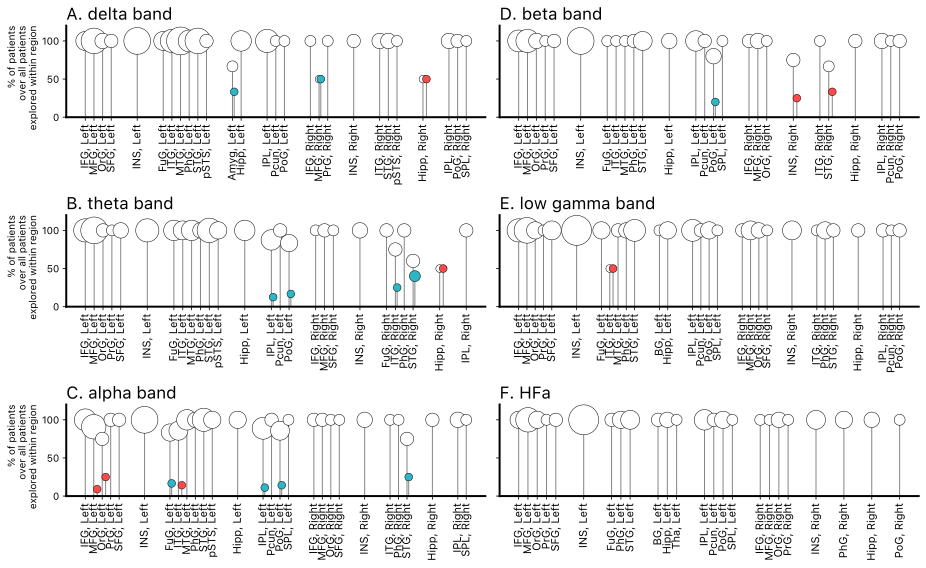

In [23]:
selects = ('speech', 'music', 'shared', )[::-1]
minimum = 1
abc = 'ABCDEF'
fig, ax = plt.subplots(3, 2, figsize=(13, 8), sharey=True)
for b, band in enumerate(bands):
    axes = ax[b % 3, int(b/3)]
    columns = ['spectral_%s_%s_noout_sign' %
               (sound, band) for sound in sounds]
    s_df = df.loc[(df[columns].notnull().any(axis=1))]
    counter = 0
    ylabels = []
    yticks = []
    for hem, lobe in product(('Left', 'Right', ), lobes):
        counter += 1
        for j, r in enumerate(regions[hem][lobe]):
            total_s = 0
            for select in selects:
                b_d[select] = 0
            temp = s_df.loc[(s_df['brainnetome']).str.startswith(r)]
            nrsujs = len(set(temp['subject']))
            nrelecs = len(df.loc[(df['brainnetome']).str.startswith(r)])
            for subject in set(temp['subject']):
                t = temp.loc[(temp['subject'] == subject)]
                if len(t) > minimum:
                    if not all([len(
                            t['spectral_%s_%s_noout_sign' % (sound, band)].dropna()) for sound in sounds]):
                        if len(t['spectral_difference_%s_sign' % band].dropna()):
                            if len(t['spectral_%s_%s_noout_sign' % ('speech', band)].dropna()):
                                total_s += 1
                                b_d['speech'] += 1
                            else:
                                total_s += 1
                                b_d['music'] += 1
                    else:
                        if len(t.loc[~(t['spectral_difference_%s_sign' % band] > 0)]):
                            total_s += 1
                            b_d['shared'] += 1
            if total_s > minimum:
                counter += .5
                for c, k in enumerate(selects):
                    xmap = bayesprev.map(b_d[k], total_s, alpha)
                    if xmap == 0:
                        continue
                    label = jn(r.split(' ')[:2], ' ')
                    if label not in ylabels:
                        ylabels.append(jn(r.split(' ')[:2], ' '))
                        yticks.append(counter)
                    perc = (b_d[k]/total_s) * 100
                    axes.plot([counter + (c/10), counter + (c/10)],
                              [0, perc],
                              linewidth=1,
                              zorder=1,
                              color=color['neither_grey'][2] / 255)
                    axes.scatter(counter + (c/10),
                                 perc, s=b_d[k]*60,
                                 facecolor=np.append((color[k][1] / 255), 1),
                                 linewidth=.5,
                                 edgecolor='k',
                                 label=b_d[k],
                                 zorder=2,
                                 alpha=1)
    if band == 'hfa':
        band = 'HFa'
    elif band == 'lga':
        band = 'low gamma'

    axes.set_title('%s. %s %s' % (
        abc[b], band, 'band' if band != 'HFa' else ''), fontsize=17, font=my_fonts('regular'))
    axes.set_xticks(yticks)
    axes.set_xticklabels(ylabels, rotation=90, fontsize=11)
    axes.xaxis.grid(False)
    axes.yaxis.grid(False)
    axes.set_ylim([0, 120])
    if b < 3:
        axes.set_ylabel(
            '% of patients\nover all patients\nexplored within region')

fig.tight_layout()